<a href="https://colab.research.google.com/github/kithmiGunawardna/Hate_Speech_detection/blob/master/Deep_learning_model_hate_speech_detection_using_pretrained_embadding_(CNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade gensim
!pip install keras-preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.3 MB/s eta 0:00:00


In [ ]:
#import relevant libraraies
import pandas as pd
import numpy as np
from google.colab import drive

#imprtant libraris for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for deep learning

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

import gensim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import re
import string
from sklearn.utils import resample
from spacy.lang.en import English
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split

#word embading using pretrain model
from gensim.models import Word2Vec
from matplotlib import pyplot
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer

#BILSTM model
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.initializers import Constant
from keras.callbacks import EarlyStopping

#validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score



#hide warning
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.preprocessing.sequence import pad_sequences


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


 0 - hate speech 1 - offensive language 2 - neither

In [ ]:
#import dataset
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/Campus_Research/labeled_data.csv')

Mounted at /content/drive


In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


**Cleaning the dataset**

In [ ]:
#preprossesing part
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  stripped_mentions = tf.strings.regex_replace(stripped_html, r"@\w+", " ")
  stripped_hashtags = tf.strings.regex_replace(stripped_mentions, r"#\w+", " ")
  # Expand emoticons with appropriate library
  # stripped_emoticons = ...
  stripped_urls = tf.strings.regex_replace(stripped_hashtags, r"http(?s://)?\S+", " ")
  # Remove punctuation (existing logic)
  return tf.strings.regex_replace(stripped_urls, '[%s]' % re.escape(string.punctuation), '').numpy().decode('utf-8')

In [ ]:
# Apply clean_text function
df.loc[:, 'tweet'] = df['tweet'].apply(custom_standardization)

In [ ]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,rt as a woman you shouldnt complain about c...
1,1,3,0,3,0,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,2,3,0,3,0,1,rt dawg rt you ever fuck a bitch and she ...
3,3,3,0,2,1,1,rt she look like a tranny
4,4,6,0,6,0,1,rt the shit you hear about me might be true...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,yous a muthafin lie right his tl is tra...
24779,25292,3,0,1,2,2,youve gone and broke the wrong heart baby and ...
24780,25294,3,0,3,0,1,young buck wanna eat dat nigguh like i aint fu...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [ ]:
df['tweet']

,tweet
0,rt as a woman you shouldnt complain about c...
1,rt boy dats coldtyga dwn bad for cuffin dat...
2,rt dawg rt you ever fuck a bitch and she ...
3,rt she look like a tranny
4,rt the shit you hear about me might be true...
...,...
24778,yous a muthafin lie right his tl is tra...
24779,youve gone and broke the wrong heart baby and ...
24780,young buck wanna eat dat nigguh like i aint fu...
24781,youu got wild bitches tellin you lies


In [ ]:
df1 =df[['class', 'tweet']]
df1



,class,tweet
0,2,rt as a woman you shouldnt complain about c...
1,1,rt boy dats coldtyga dwn bad for cuffin dat...
2,1,rt dawg rt you ever fuck a bitch and she ...
3,1,rt she look like a tranny
4,1,rt the shit you hear about me might be true...
...,...,...
24778,1,yous a muthafin lie right his tl is tra...
24779,2,youve gone and broke the wrong heart baby and ...
24780,1,young buck wanna eat dat nigguh like i aint fu...
24781,1,youu got wild bitches tellin you lies


**Unbalanced data set**

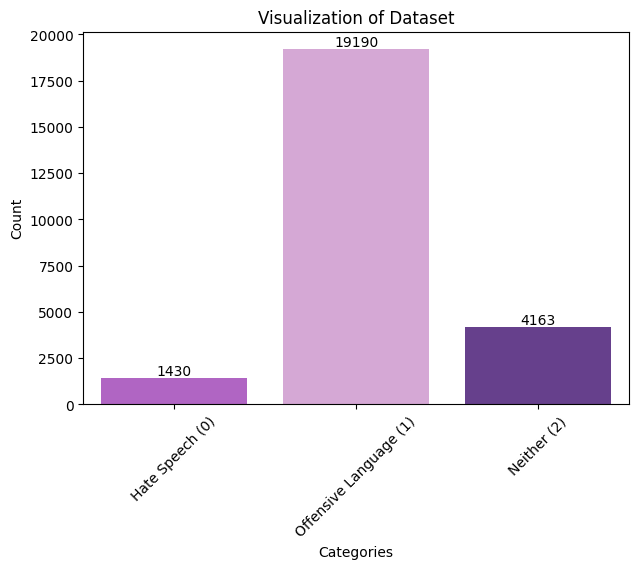

In [ ]:
# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['mediumorchid', 'plum', 'rebeccapurple']  # Purple shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')





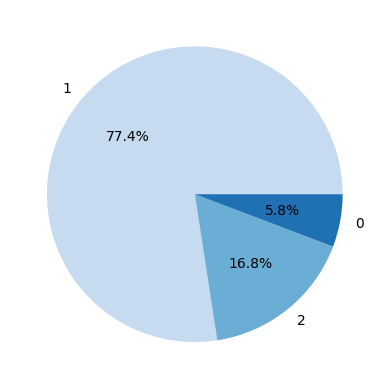

In [ ]:
blue_palette = sns.color_palette("Blues", n_colors=3)  # Customize 'n_colors' based on the number of slices

# Create a pie chart with the blue color palette
plt.pie(
    df['class'].value_counts().values,  # Values for the pie chart
    labels=df['class'].value_counts().index,  # Labels for each slice
    autopct='%1.1f%%',  # Display the percentage with one decimal place
    colors=blue_palette  # Set the color palette to shades of blue
)

# Display the pie chart
plt.show()

In [ ]:
y = df['class']
x = df.tweet

 **Balanced dataset using oversampling**

In [ ]:
#create two different dataframe of majority and minority class
df_class_1 = df1[(df1['class']==1)]
df_class_2 = df1[(df1['class']==2)]
df_class_0 = df1[(df1['class']==0)]
# undersample class_1 class
df_class_2_oversampled = resample(df_class_2,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# undersample class_1 class
df_class_0_oversampled = resample(df_class_0,
                                 replace=True,    # sample with replacement
                                 n_samples= len(df_class_1), # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
oversampled_df  = pd.concat([df_class_2_oversampled, df_class_0_oversampled,df_class_1])

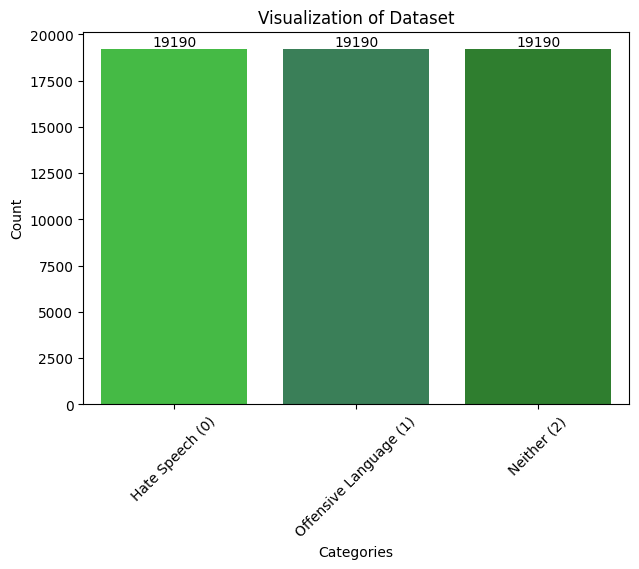

In [ ]:

# Data
category = ['Hate Speech (0)', 'Offensive Language (1)', 'Neither (2)']
count = oversampled_df['class'].value_counts()
value_count = [count[0], count[1], count[2]]

# Define a purple color palette for the bar plot
bar_colors = ['limegreen', 'seagreen', 'forestgreen']  # green shades

# Create a bar chart with Seaborn
# Customize the plot
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Visualization of Dataset')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
for bar in sns.barplot(x=category, y=value_count, palette=bar_colors).patches:
  plt.annotate(int(bar.get_height()),
              (bar.get_x() + bar.get_width() / 2, bar.get_height()),
              ha='center', va='bottom')

In [ ]:
oversampled_df

,class,tweet
5073,2,nope super chocolatey yummy brownies
22172,2,thou shall not mock ryanthe futurekelly
18219,2,rt my trash is worth more than you
2869,2,penske runs the 22 in nascar its yellow ther...
20198,2,rt a birds eye view of todays activities t...
...,...,...
24774,1,you really care bout dis bitch my dick all in ...
24775,1,you worried bout other bitches you need me for
24778,1,yous a muthafin lie right his tl is tra...
24780,1,young buck wanna eat dat nigguh like i aint fu...


In [ ]:
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Campus_Research/GoogleNews-vectors-negative300.bin.gz', binary=True)


**Tokanization**

In [ ]:
tk = nltk.tokenize.TreebankWordTokenizer()
# Tokenizing the 'tweet' column
tweet_tokens = [tk.tokenize(tweet) for tweet in oversampled_df['tweet']]

# Assign the tokenized output back to the DataFrame if needed
oversampled_df['tweet_tokens'] = tweet_tokens


In [ ]:
oversampled_df

,class,tweet,tweet_tokens
5073,2,nope super chocolatey yummy brownies,"[nope, super, chocolatey, yummy, brownies]"
22172,2,thou shall not mock ryanthe futurekelly,"[thou, shall, not, mock, ryanthe, futurekelly]"
18219,2,rt my trash is worth more than you,"[rt, my, trash, is, worth, more, than, you]"
2869,2,penske runs the 22 in nascar its yellow ther...,"[penske, runs, the, 22, in, nascar, its, yello..."
20198,2,rt a birds eye view of todays activities t...,"[rt, a, birds, eye, view, of, todays, activiti..."
...,...,...,...
24774,1,you really care bout dis bitch my dick all in ...,"[you, really, care, bout, dis, bitch, my, dick..."
24775,1,you worried bout other bitches you need me for,"[you, worried, bout, other, bitches, you, need..."
24778,1,yous a muthafin lie right his tl is tra...,"[yous, a, muthafin, lie, right, his, tl, is, t..."
24780,1,young buck wanna eat dat nigguh like i aint fu...,"[young, buck, wan, na, eat, dat, nigguh, like,..."


In [ ]:
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))  # Corrected stopword access
    # Remove stop words and return tokenized data
    return [word for word in tokens if word.lower() not in stop_words]


In [ ]:
# Apply remove stopword function
oversampled_df['tweet_tokens'] = oversampled_df['tweet_tokens'].apply(remove_stopwords)

In [ ]:
oversampled_df

,class,tweet,tweet_tokens
5073,2,nope super chocolatey yummy brownies,"[nope, super, chocolatey, yummy, brownies]"
22172,2,thou shall not mock ryanthe futurekelly,"[thou, shall, mock, ryanthe, futurekelly]"
18219,2,rt my trash is worth more than you,"[rt, trash, worth]"
2869,2,penske runs the 22 in nascar its yellow ther...,"[penske, runs, 22, nascar, yellow, theres, spo..."
20198,2,rt a birds eye view of todays activities t...,"[rt, birds, eye, view, todays, activities, tha..."
...,...,...,...
24774,1,you really care bout dis bitch my dick all in ...,"[really, care, bout, dis, bitch, dick, yo, fee..."
24775,1,you worried bout other bitches you need me for,"[worried, bout, bitches, need]"
24778,1,yous a muthafin lie right his tl is tra...,"[yous, muthafin, lie, right, tl, trash, mine, ..."
24780,1,young buck wanna eat dat nigguh like i aint fu...,"[young, buck, wan, na, eat, dat, nigguh, like,..."


**word embading using pre trained model**

**word2Vec**

In [ ]:
word2vec_model = Word2Vec(sentences=oversampled_df['tweet_tokens'], vector_size=128, window=5, min_count=1, workers=4)


In [ ]:
# Create the embedding matrix from Word2Vec
def create_embedding_matrix(word2vec_model, word_index, embedding_dim):
    num_words = len(word_index) + 1
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    return embedding_matrix


**Train Test split**

In [ ]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(oversampled_df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 20654 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(oversampled_df['tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (57570, 250)


In [ ]:
Y = pd.get_dummies(oversampled_df['class']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (57570, 3)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

 **CNN Model**

In [ ]:
embedding_matrix = create_embedding_matrix(word2vec_model, word_index, EMBEDDING_DIM)

In [ ]:
model = Sequential()

# Embedding layer with pre-trained Word2Vec embeddings
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)  # Set trainable to False to keep the pre-trained embeddings fixed

model.add(embedding_layer)

# Convolutional Layer
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Add dropout to prevent overfitting
model.add(Dense(len(Y[0]), activation='softmax'))  # Output layer with the number of classes

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       2,643,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,643,840 (10.09 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,643,840 (10.09 MB)

None


In [ ]:
# Define EarlyStopping with a desired metric and patience level
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop after 3 epochs with no improvement
    restore_best_weights=True,  # Restore the best model weights
    mode='min'  # 'min' to minimize the monitored metric (loss)
)


In [ ]:
epochs = 10
batch_size = 64

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[early_stopping],verbose=2)
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Epoch 1/10
567/567 - 13s - 23ms/step - accuracy: 0.6597 - loss: 0.7427 - val_accuracy: 0.7218 - val_loss: 0.6119
Epoch 2/10
567/567 - 2s - 3ms/step - accuracy: 0.7611 - loss: 0.5583 - val_accuracy: 0.7923 - val_loss: 0.4916
Epoch 3/10
567/567 - 2s - 3ms/step - accuracy: 0.8021 - loss: 0.4677 - val_accuracy: 0.8065 - val_loss: 0.4654
Epoch 4/10
567/567 - 2s - 3ms/step - accuracy: 0.8302 - loss: 0.4001 - val_accuracy: 0.8350 - val_loss: 0.3962
Epoch 5/10
567/567 - 2s - 3ms/step - accuracy: 0.8460 - loss: 0.3617 - val_accuracy: 0.8395 - val_loss: 0.3723
Epoch 6/10
567/567 - 2s - 3ms/step - accuracy: 0.8600 - loss: 0.3299 - val_accuracy: 0.8546 - val_loss: 0.3681
Epoch 7/10
567/567 - 2s - 3ms/step - accuracy: 0.8702 - loss: 0.3074 - val_accuracy: 0.8650 - val_loss: 0.3404
Epoch 8/10
567/567 - 2s - 3ms/step - accuracy: 0.8747 - loss: 0.2895 - val_accuracy: 0.8573 - val_loss: 0.3674
Epoch 9/10
567/567 - 2s - 3ms/step - accuracy: 0.8810 - loss: 0.2757 - val_accuracy: 0.8429 - val_loss: 0.4086

In [ ]:
y_pred = model.predict(x_test)

540/540 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


**Validation**

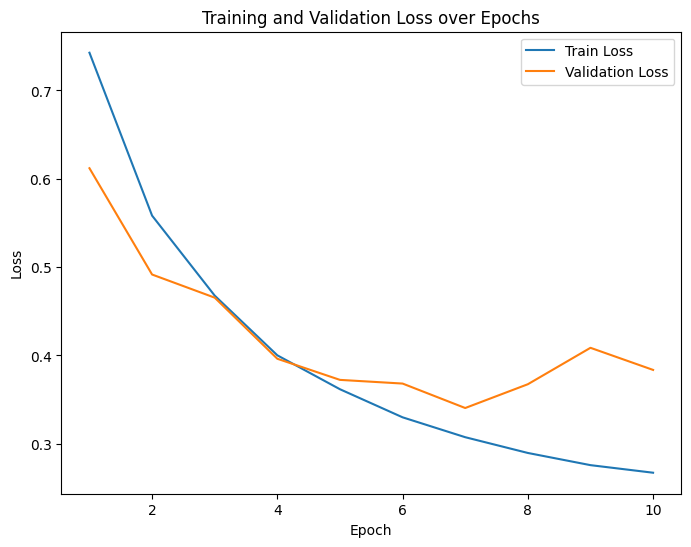

In [ ]:
epochs = list(range(1, len(history.history['loss']) + 1))  # Create a list of epochs


# Combine training and validation loss into a DataFrame
Simple_RNN_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Loss': history.history['loss'],
    'Validation Loss': history.history['val_loss'],
})

# Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Train Loss', label='Train Loss')
sns.lineplot(data=Simple_RNN_df, x='Epoch', y='Validation Loss', label='Validation Loss')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

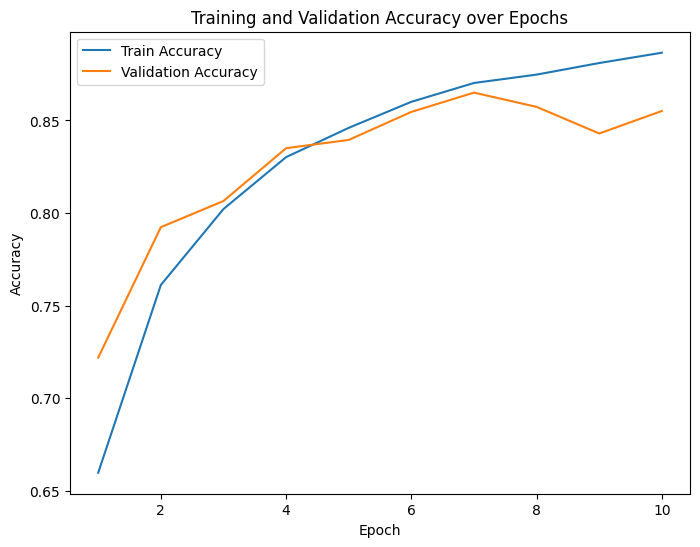

In [ ]:
epochs = list(range(1, len(history.history['accuracy']) + 1))

# Create a DataFrame for training and validation accuracy
accuracy_df = pd.DataFrame({
    'Epoch': epochs,
    'Train Accuracy': history.history['accuracy'],
    'Validation Accuracy': history.history['val_accuracy'],
})

# Plot the training and validation accuracy with Seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=accuracy_df, x='Epoch', y='Train Accuracy', label='Train Accuracy')
sns.lineplot(data=accuracy_df, x='Epoch', y='Validation Accuracy', label='Validation Accuracy')

plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<Axes: >

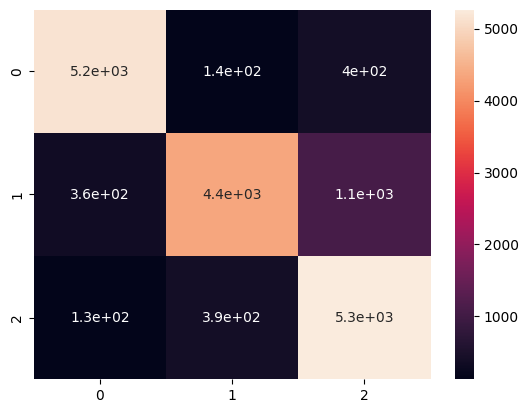

In [ ]:
cm_Lstm= confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))
sns.heatmap(data=cm_Lstm, annot=True)

In [ ]:
print(classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1),labels=[0,1,2]))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      5693
           1       0.89      0.75      0.82      5798
           2       0.78      0.91      0.84      5780

    accuracy                           0.86     17271
   macro avg       0.86      0.86      0.86     17271
weighted avg       0.86      0.86      0.86     17271



In [ ]:

# Calculate accuracy, F1-score, recall, and precision
accuracy = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))  # Calculate accuracy
f1 = f1_score(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1), average='macro')  # Calculate F1-score using macro average
recall = recall_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1), average='macro')  # Calculate recall using macro average
precision = precision_score(np.argmax(y_test,axis=1),np.argmax(y_pred,axis=1), average='macro')  # Calculate precision using macro average

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)

Accuracy: 0.8557118869781715
F1 Score: 0.8554729942494568
Recall: 0.8560704157286988
Precision: 0.8621986024190692


In [ ]:
new_array = [["you bitch"],["your're very good"],["you damn girl"]]
lables =['hate speech','offensive language','neither']

In [ ]:
for message in new_array:
  X = tokenizer.texts_to_sequences(message)
  X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  output=model.predict(X)
  print(output,lables[np.argmax(output)],message,"\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
[[0.3615146  0.27464318 0.3638422 ]] neither ['you bitch'] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.3615146  0.27464318 0.3638422 ]] neither ["your're very good"] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.3615146  0.27464318 0.3638422 ]] neither ['you damn girl'] 

